In [48]:
#Imports
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage, misc

#Sklearn
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, accuracy_score
from skimage.feature import hog, local_binary_pattern
from sklearn.decomposition import PCA

# constants
num_components=100 

In [2]:
#Load images 
train_dir = 'Data/train/'
test_dir = 'Data/test/'


#Count the number of images in the different categories in training and test set
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3952      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


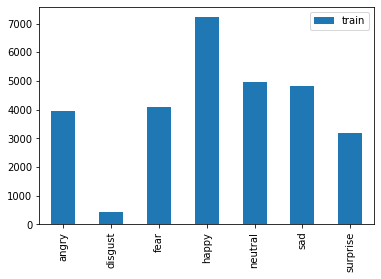

In [3]:
#Plot number of images in training set
train_count.transpose().plot(kind='bar')

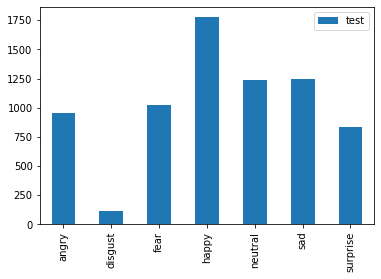

In [4]:
#Plot number of images in test set 
test_count.transpose().plot(kind='bar')

In [5]:

def load_images_from_folder(folder):
    images = []
    for expression in os.listdir(folder):
        path = folder + expression
        #print(path)
        for filename in os.listdir(path):
            #print(filename)
            img = cv2.imread(path + '/' +filename)

            if img is not None:
                images.append(img)
    return images

In [6]:
training = load_images_from_folder(train_dir)
testing = load_images_from_folder(test_dir)

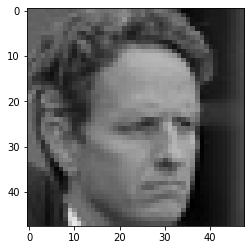

In [7]:
img = training[0]
imgplot = plt.imshow(img)
plt.show()

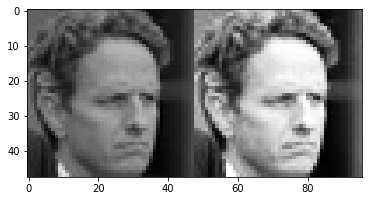

In [8]:
img = training[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
 
equ = cv2.equalizeHist(img)
res = np.hstack((img,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)
imgplot = plt.imshow(res, 'gray')
plt.show()

In [52]:
#Method to perform equalization histogram on a list of images
def equalizing(images):
    equ_hist_images = []
    for img in images:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        equ = cv2.equalizeHist(img)
        equ_hist_images.append(equ)
    return equ_hist_images

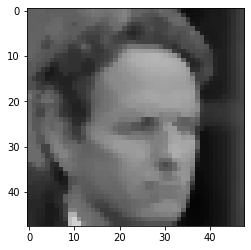

In [10]:
#Apply Median Filter
imageObject = training[0]

img_med = ndimage.median_filter(imageObject, 3)
imgplot = plt.imshow(img_med)
plt.show()


#inputs a list of images and the filtervalue (often 3)
#outputs a new list of images with the median filter applied
def apply_median_filter(images, filter_value): 
    images_med = []
    for img in images:
        img_med = ndimage.median_filter(imageObject, filter_value)
        images_med.append(img_med)
    return images_med
    

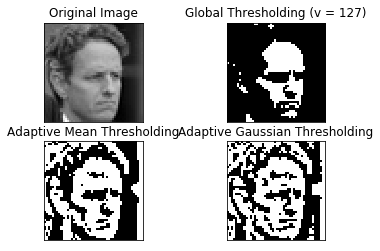

In [11]:
img = training[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
th2 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
th3 = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

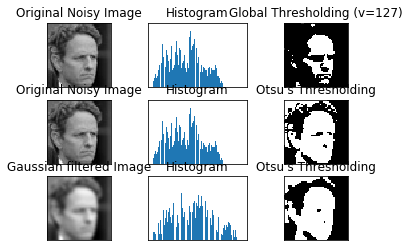

In [12]:
# global thresholding
ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
blur = cv2.GaussianBlur(img,(5,5),0)
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# plot all the images and their histograms
images = [img, 0, th1,
          img, 0, th2,
          blur, 0, th3]
titles = ['Original Noisy Image','Histogram','Global Thresholding (v=127)',
          'Original Noisy Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

for i in range(3):
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
#Apply Histogram Normalization?
#https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html


In [43]:
#Extract SIFT or SURF features from an images
def features(images): 
    #load all the algorithms 
    sift = cv2.xfeatures2d.SIFT_create()
    surf = cv2.xfeatures2d.SURF_create()
    
    images_keypoints = []
    images_descriptors = []
    for img in images:
        
        #get keypoints and descriptos from the image
        keypoints_sift, descriptors_sift = sift.detectAndCompute(img, None)
        keypoints_surf, descriptors_surf = surf.detectAndCompute(img, None)
        
        #save the keypoints and descriptors for each image
        images_keypoints.append(keypoints_sift)
        images_descriptors.append(descriptors_sift)
    
        #Draw keypoints on the image
        img_sift = cv2.drawKeypoints(img, keypoints_sift, None)
        img_surf = cv2.drawKeypoints(img, keypoints_surf, None)
    
        images_with_keypoints = [img_sift, img_surf]
    return images_keypoints, images_descriptors, images_with_keypoints

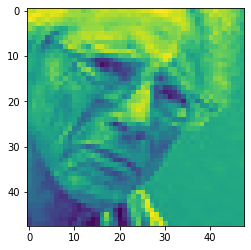

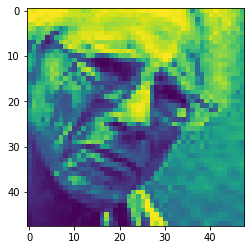

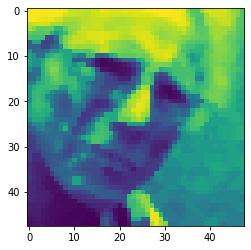

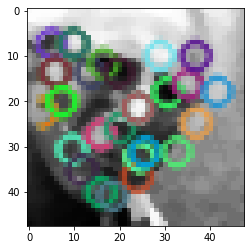

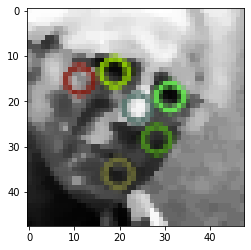

In [44]:
img = training[1]
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
imgplot = plt.imshow(img)
plt.show()

equ = cv2.equalizeHist(img)
imgplot = plt.imshow(equ)
plt.show()

img_med = ndimage.median_filter(equ, 3)
imgplot = plt.imshow(img_med)
plt.show()

#Otsu's thresholding
#ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

imgtemp = [img_med]

keypoints, descriptors, images = features(imgtemp)

imgplot = plt.imshow(images[0])
plt.show()

imgplot = plt.imshow(images[1])
plt.show()


In [57]:
#Test on entire list
training_equalized = equalizing(training)
training_equalized_median = apply_median_filter(training_equalized, 3)
keypoints_training, descriptors_training, images_training = features(training_equalized_median)

In [58]:
# descriptors = list of feature descriptors
# emModel = pre-trained GMM model
def buildHistograms(descriptors, emModel):
    histograms = []
    for descriptor in descriptors:
        histogram = np.zeros(len(em.means_))
        for i in emModel.predict(descriptor):
            histogram[i] += 1.0
        histograms.append(histogram)
    return histograms

# cluster descriptors into K clusters using the Gaussian Mixture model
em = GaussianMixture(n_components=num_components)
em = em.fit(np.concatenate(descriptors_training))

trainHistograms = buildHistograms(descriptors_training, em)

for i in np.random.randint(0, len(trainHistograms), 3):
    plt.hist(trainHistograms[i], bins=int(np.max(trainHistograms[i]) + 1)) # bins=num_components)
    plt.title("Descriptor {}".format(i))
    plt.show()

C:\Users\annab\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:969: ConvergenceWarning: Number of distinct clusters (23) found smaller than n_clusters (100). Possibly due to duplicate points in X.
  return_n_iter=True)


KeyboardInterrupt: 